In [1]:
# import os
# os.chdir('gpas/mmm-2x2-truth')

# MMM-Oxford 2x2 SARS-CoV-2 truth set

Comparing SARS2-positive samples from a mixture of cultured and high Ct patient samples using combinations of:
1. Nanopore and Illumina sequencing
2. ARTIC v3 amplicon sequencing and SISPA whole genome amplification

Google sheet of same dataset:   
https://docs.google.com/spreadsheets/d/1KMx9o2oypW8BM9LW1xVD6_wKTUcnagtBiA4c6LUBwgw

---

## Notes


### Locations
- OCI bucket: `SARS-CoV-2_reference_ox`
- MMM `analysis1`: `/home/ndm.local/bede/covid/truth/fastq/`

### Filename construction
- Oxford Nanopore (`platform == 'ont'`)
    - `{name}.fastq.gz` (e.g. `mmm-artic-ill__Brazil_P.1_33329_P2D2__1.fastq.gz`)
 
- Illumina (`platform == 'ill'`):
    - `{name}.r1.fastq.gz` (e.g. `mmm-artic-ill__Brazil_P.1_33329_P2D2__1.r1.fastq.gz`)
    - `{name}.r2.fastq.gz` (e.g. `mmm-artic-ill__Brazil_P.1_33329_P2D2__1.r2.fastq.gz`)

`{fastq_filename}` field includes asterisk for globbing r1 and r2.

### Fields

`replicate` refers to a given sample-platform-amplification combination

### QC

- `cov20_pc` and `median_depth` calculated from minimap2+samtools depths output using reference `MN908947.3`  
- Pangolin currently called using ARTIC Fieldbioinformatics consensus sequence for ARTIC-Nanopore data only, extrapolated to Illumina and SISPA

### Caveats

- Pangolin assignments currently incomplete; to be rerun using platform-amplfication agnostic pipeline?
- Some samples have poor coverage, usually for SISPA
- Currently fastq only, however Nanopore fast5s are available

In [2]:
import datetime
import pandas as pd

today = datetime.date.today().isoformat()

%config InlineBackend.figure_format = 'retina'

In [3]:
df = pd.read_csv('mmm-2x2-truth.2021-06-28.csv')
print(f'Length: {df.shape[0]}')
df.head(1)

Length: 309


,name,class_,sample,platform,amplification,replicate,fastq_filename,cov20_pc,median_depth,pangolin_lineage,pangolin_version
0,mmm-artic-ill__Brazil_P.1_33329_P2D2__1,mmm-artic-ill,Brazil_P.1_33329_P2D2,ill,artic,1,mmm-artic-ill__Brazil_P.1_33329_P2D2__1*.fastq.gz,99.771689,8734,P.1,3.1.5


## Lineage distribution

<AxesSubplot:>

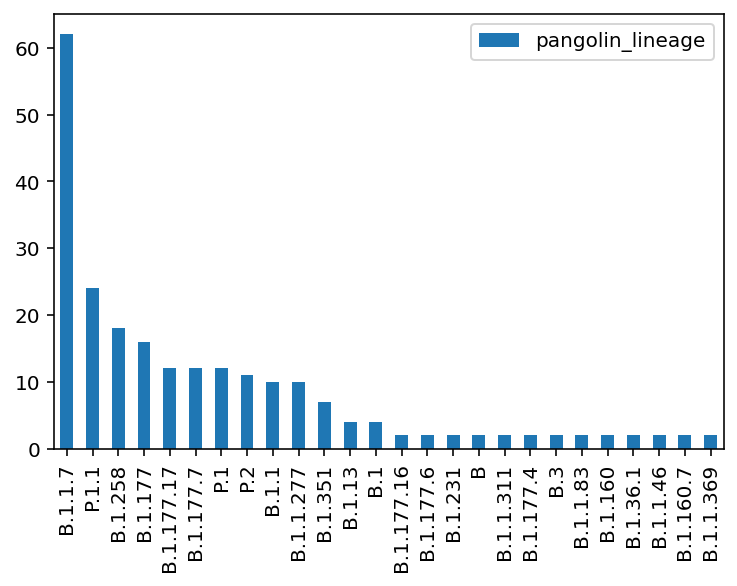

In [4]:
df.pangolin_lineage.value_counts().to_frame().plot.bar()

## Samples for which 2x2 comparison is available

In [5]:
twobytwo_df = (df.groupby('sample')
 .nunique()
 .sort_values(by=['class_', 'sample'], ascending=[False, True])['class_']
 .rename('distinct_amplification_platforms')
 .to_frame()
 .query("distinct_amplification_platforms == 4"))

twobytwo_samples = set(twobytwo_df.index)
print(len(twobytwo_samples))
# twobytwo_df


twobytwo_95_df = (df.query("cov20_pc > 95").groupby('sample')
 .nunique()
 .sort_values(by=['class_', 'sample'], ascending=[False, True])['class_']
 .rename('distinct_amplification_platforms')
 .to_frame()
 .query("distinct_amplification_platforms == 4"))

twobytwo_95_samples = set(twobytwo_95_df.index)
print(len(twobytwo_95_samples))
twobytwo_95_df

23
12


,distinct_amplification_platforms
sample,
Brazil_P.1_33329_P2D2,4
Brazil_P.1_3522_P1D4,4
Brazil_P.1_3522_P2D2,4
Brazil_P.2_30270_P1E6,4
Brazil_P.2_30270_P2D2,4
GS_SA,4
GS_kentPHE,4
N206750,4
N211472,4


## ARTIC v3: lineage calling subset for testing

- **25 ARTIC samples with matched ONT + Illumina**
- Distinct lineages
- `cov20_pc > 95`
- `pangolin_lineage` is not `NaN`

In [6]:
lineages_subset_df = (df.query("amplification == 'artic' and cov20_pc > 95 and pangolin_lineage == pangolin_lineage").groupby(['sample'])
 .nunique()
 .sort_values(by=['class_', 'sample'], ascending=[False, True])['class_']
 .rename('distinct_amplification_platforms')
 .to_frame()
 .query("distinct_amplification_platforms == 2"))

lineages_subset_samples = set(lineages_subset_df.index)

lineages_subset_samples_ont_df = (df.query("sample in @lineages_subset_samples and amplification == 'artic' and cov20_pc > 95 and platform == 'ont'")
                                  .sort_values(['cov20_pc', 'replicate'], ascending=[False, True])
                                  .drop_duplicates(['sample'])
                                  .sort_values('sample')
                                  .drop_duplicates('pangolin_lineage'))
lineages_subset_samples_ill_df = (df.query("sample in @lineages_subset_samples and amplification == 'artic' and cov20_pc > 95 and platform == 'ill'")
                                  .sort_values(['cov20_pc', 'replicate'], ascending=[False, True])
                                  .drop_duplicates(['sample'])
                                  .sort_values('sample')
                                  .drop_duplicates('pangolin_lineage'))

print(lineages_subset_samples_ont_df.shape[0], lineages_subset_samples_ill_df.shape[0])

lineages_subset_samples_both_df = pd.concat([lineages_subset_samples_ont_df, lineages_subset_samples_ill_df]).sort_values(['sample', 'platform'], ascending=[True, False])
lineages_subset_samples_both_df['test_pair'] = lineages_subset_samples_both_df.groupby('sample').ngroup()

lineages_subset_samples_both_df.to_csv(f'test_lineage_assignment.{today}.csv', index=False)

25 25


## ARTIC v3: lineage calling subset for testing

- **10 samples x 2 replicates (ONT)**
- **11 samples x 2 replicates (Illumina)**
- Distinct lineages
- `cov20_pc > 95`
- `pangolin_lineage` is not `NaN`

In [7]:
repro_subset_ont_df = (df.query("amplification == 'artic' and cov20_pc > 95 and platform == 'ont' and pangolin_lineage == pangolin_lineage").groupby(['sample'])
                   .nunique()['replicate']
                   .to_frame()
                   .query("replicate >= 2")
                   .join(df.set_index('sample')['pangolin_lineage']).drop_duplicates('pangolin_lineage'))
repro_subset_samples_ont = set(repro_subset_ont_df.index)
repro_subset_samples_ont_df = df.query("sample in @repro_subset_samples_ont and amplification == 'artic' and cov20_pc > 95 and platform == 'ont'").sort_values(['cov20_pc', 'replicate'], ascending=[False, True]).groupby('sample').head(2).sort_values(['sample', 'replicate'])
repro_subset_samples_ont_df.to_csv(f'test_repro_assignment_ont.{today}.csv', index=False)

repro_subset_ill_df = (df.query("amplification == 'artic' and cov20_pc > 95 and platform == 'ill' and pangolin_lineage == pangolin_lineage").groupby(['sample'])
                   .nunique()['replicate']
                   .to_frame()
                   .query("replicate >= 2")
                   .join(df.set_index('sample')['pangolin_lineage']).drop_duplicates('pangolin_lineage'))
repro_subset_samples_ill = set(repro_subset_ill_df.index)
repro_subset_samples_ill_df = df.query("sample in @repro_subset_samples_ill and amplification == 'artic' and cov20_pc > 95 and platform == 'ill'").sort_values(['cov20_pc', 'replicate'], ascending=[False, True]).groupby('sample').head(2).sort_values(['sample', 'replicate'])
repro_subset_samples_ill_df.to_csv(f'test_repro_assignment_ill.{today}.csv', index=False)

print(repro_subset_samples_ont_df.shape[0], repro_subset_samples_ill_df.shape[0])

20 22


## Everything

In [8]:
pd.set_option('display.max_rows', 500)
df

,name,class_,sample,platform,amplification,replicate,fastq_filename,cov20_pc,median_depth,pangolin_lineage,pangolin_version
0,mmm-artic-ill__Brazil_P.1_33329_P2D2__1,mmm-artic-ill,Brazil_P.1_33329_P2D2,ill,artic,1,mmm-artic-ill__Brazil_P.1_33329_P2D2__1*.fastq.gz,99.771689,8734,P.1,3.1.5
1,mmm-artic-ill__Brazil_P.1_33329_P2D2__2,mmm-artic-ill,Brazil_P.1_33329_P2D2,ill,artic,2,mmm-artic-ill__Brazil_P.1_33329_P2D2__2*.fastq.gz,99.969782,2474,P.1,3.1.5
2,mmm-artic-ill__Brazil_P.1_33329_P2D2__3,mmm-artic-ill,Brazil_P.1_33329_P2D2,ill,artic,3,mmm-artic-ill__Brazil_P.1_33329_P2D2__3*.fastq.gz,99.969782,7507,P.1,3.1.5
3,mmm-artic-ont__Brazil_P.1_33329_P2D2__1,mmm-artic-ont,Brazil_P.1_33329_P2D2,ont,artic,1,mmm-artic-ont__Brazil_P.1_33329_P2D2__1*.fastq.gz,100.000000,961,P.1,3.1.5
4,mmm-artic-ont__Brazil_P.1_33329_P2D2__2,mmm-artic-ont,Brazil_P.1_33329_P2D2,ont,artic,2,mmm-artic-ont__Brazil_P.1_33329_P2D2__2*.fastq.gz,100.000000,2956,P.1,3.1.5
5,mmm-artic-ont__Brazil_P.1_33329_P2D2__3,mmm-artic-ont,Brazil_P.1_33329_P2D2,ont,artic,3,mmm-artic-ont__Brazil_P.1_33329_P2D2__3*.fastq.gz,100.000000,4068,P.1,3.1.5
6,mmm-sispa-ill__Brazil_P.1_33329_P2D2__1,mmm-sispa-ill,Brazil_P.1_33329_P2D2,ill,sispa,1,mmm-sispa-ill__Brazil_P.1_33329_P2D2__1*.fastq.gz,100.000000,11651,P.1,3.1.5
7,mmm-sispa-ill__Brazil_P.1_33329_P2D2__2,mmm-sispa-ill,Brazil_P.1_33329_P2D2,ill,sispa,2,mmm-sispa-ill__Brazil_P.1_33329_P2D2__2*.fastq.gz,100.000000,9957,P.1,3.1.5
8,mmm-sispa-ill__Brazil_P.1_33329_P2D2__3,mmm-sispa-ill,Brazil_P.1_33329_P2D2,ill,sispa,3,mmm-sispa-ill__Brazil_P.1_33329_P2D2__3*.fastq.gz,99.996642,7626,P.1,3.1.5
9,mmm-sispa-ont__Brazil_P.1_33329_P2D2__1,mmm-sispa-ont,Brazil_P.1_33329_P2D2,ont,sispa,1,mmm-sispa-ont__Brazil_P.1_33329_P2D2__1*.fastq.gz,100.000000,647,P.1,3.1.5
